# Am I the AHole Dataset Construction

Constructing datasets for the AITA subreddit as an exercise using AllenNLP.

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')

from subreddit_frequency import load_dataframe_from_jsonl
from tqdm import tqdm
tqdm.pandas()

import seaborn as sns
from datetime import datetime
sns.set('paper')

from ipywidgets import interact
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

## Data Loading

Loads the data from sharded files, need to rebuild and concatonate.
May take up a lot of memory, so runon a computer with enough RAM.

In [3]:
submissions_df = pd.concat([
    load_dataframe_from_jsonl(a)
    for a in Path("../data").glob("RS_*Asshole.dump")
],axis=0)

93it [00:00, 15350.45it/s]
104it [00:00, 20029.74it/s]
94it [00:00, 13392.59it/s]
128it [00:00, 19030.55it/s]
0it [00:00, ?it/s]
360it [00:00, 31757.65it/s]
116it [00:00, 18654.22it/s]
104it [00:00, 26008.09it/s]
130it [00:00, 17527.95it/s]
106it [00:00, 25775.19it/s]
333it [00:00, 31597.48it/s]
110it [00:00, 50340.80it/s]
1926it [00:00, 19253.18it/s]

../data/RS_2016-04.zst_AmItheAsshole.dump
../data/RS_2016-08.zst_AmItheAsshole.dump
../data/RS_2016-06.zst_AmItheAsshole.dump
../data/RS_2016-01.zst_AmItheAsshole.dump
../data/RS_2019-09.zst_AmItheAsshole.dump
../data/RS_2017-09.bz2_AmItheAsshole.dump
../data/RS_2016-09.zst_AmItheAsshole.dump
../data/RS_2017-05.bz2_AmItheAsshole.dump
../data/RS_2017-01.bz2_AmItheAsshole.dump
../data/RS_2017-03.bz2_AmItheAsshole.dump
../data/RS_2017-11.bz2_AmItheAsshole.dump
../data/RS_2016-07.zst_AmItheAsshole.dump
../data/RS_2019-05.zst_AmItheAsshole.dump


27375it [00:00, 28734.87it/s]
154it [00:00, 48185.22it/s]
102it [00:00, 49868.17it/s]
339it [00:00, 46563.70it/s]
113it [00:00, 38237.70it/s]
3895it [00:00, 7275.45it/s]

../data/RS_2016-12.zst_AmItheAsshole.dump
../data/RS_2016-11.zst_AmItheAsshole.dump
../data/RS_2017-10.bz2_AmItheAsshole.dump
../data/RS_2017-06.bz2_AmItheAsshole.dump
../data/RS_2019-06.zst_AmItheAsshole.dump


28643it [00:01, 24914.90it/s]
136it [00:00, 41425.22it/s]
88it [00:00, 16493.09it/s]
98it [00:00, 25543.24it/s]
2553it [00:00, 25528.38it/s]

../data/RS_2017-07.bz2_AmItheAsshole.dump
../data/RS_2016-05.zst_AmItheAsshole.dump
../data/RS_2016-03.zst_AmItheAsshole.dump
../data/RS_2018-12.zst_AmItheAsshole.dump


7561it [00:00, 18062.18it/s]
104it [00:00, 38160.06it/s]
918it [00:00, 26407.49it/s]
97it [00:00, 40664.42it/s]
2629it [00:00, 26289.08it/s]

../data/RS_2017-08.bz2_AmItheAsshole.dump
../data/RS_2019-07.zst_AmItheAsshole.dump
../data/RS_2016-10.zst_AmItheAsshole.dump
../data/RS_2018-11.zst_AmItheAsshole.dump


6479it [00:00, 26204.09it/s]
2481it [00:00, 24808.13it/s]

../data/RS_2019-01.zst_AmItheAsshole.dump


11577it [00:00, 27289.83it/s]
2820it [00:00, 28197.54it/s]

../data/RS_2019-08.zst_AmItheAsshole.dump


34476it [00:01, 22793.74it/s]
2632it [00:00, 26316.32it/s]

../data/RS_2019-04.zst_AmItheAsshole.dump


26443it [00:01, 22327.58it/s]
139it [00:00, 37219.63it/s]
2582it [00:00, 25816.58it/s]

../data/RS_2017-04.bz2_AmItheAsshole.dump
../data/RS_2019-03.zst_AmItheAsshole.dump


23976it [00:00, 31003.20it/s]
2507it [00:00, 25060.46it/s]

../data/RS_2019-02.zst_AmItheAsshole.dump


15621it [00:00, 18324.62it/s]
94it [00:00, 38453.58it/s]
115it [00:00, 46455.26it/s]

../data/RS_2017-02.bz2_AmItheAsshole.dump
../data/RS_2016-02.zst_AmItheAsshole.dump



/home/johnkeszler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [4]:
comments_df = pd.concat([
    load_dataframe_from_jsonl(a)
    for a in Path("../data").glob("RC_*Asshole.dump")
],axis=0)

2035it [00:00, 95255.94it/s]
3893it [00:00, 38919.46it/s]

../data/RC_2016-11.bz2_AmItheAsshole.dump
../data/RC_2019-05.zst_AmItheAsshole.dump


1120561it [00:28, 39271.88it/s]
1555it [00:00, 18779.02it/s]
2288it [00:00, 89374.32it/s]
1186it [00:00, 76023.48it/s]
0it [00:00, ?it/s]

../data/RC_2016-09.bz2_AmItheAsshole.dump
../data/RC_2016-12.bz2_AmItheAsshole.dump
../data/RC_2016-03.bz2_AmItheAsshole.dump
../data/RC_2019-02.zst_AmItheAsshole.dump


508604it [00:13, 37705.45it/s]
1731it [00:00, 31024.44it/s]
3596it [00:00, 35955.92it/s]

../data/RC_2017-07.bz2_AmItheAsshole.dump
../data/RC_2019-04.zst_AmItheAsshole.dump


117960it [00:02, 52196.54it/s]

limit_output extension: Maximum message size of 10000 exceeded with 10023 characters

## Dataset Statistics

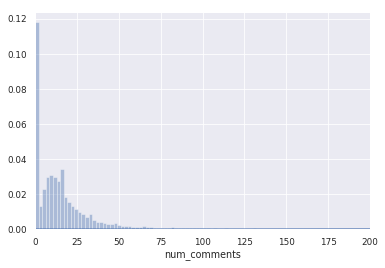

In [6]:
#print(comments_df.created_utc.conve.describe())
sns.distplot(submissions_df.num_comments,bins=5000, kde=True);
plt.xlim(0,200)
plt.show()

In [7]:
submissions_df.score.describe()

count    186326.000000
mean        101.364587
std        1051.081844
min           0.000000
25%           1.000000
50%           2.000000
75%           7.000000
max       66384.000000
Name: score, dtype: float64

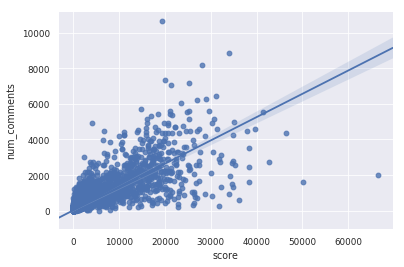

In [8]:
sns.regplot(x='score', y='num_comments', data=submissions_df)
plt.show()

Preprocess the comment to have:
* the id of the previous post that it is a comment to
* the absolute value of the score

## Helper Functions

Helper functions to:
1. Get comments from ID
2. Determine if someone is an AH

In [9]:
def get_comments_from_id(df, parent_id):
    cols = ['author_flair_text', 'stickied', 'author', 'body', 'score', 'score_abs', 'judgement']
    return df[df.prev_id == parent_id][cols]

In [10]:
def determine_AH(body):
    """Determines if poster thinks asshole or not asshole."""
    if body.startswith("YTA"):
        return "YTA"
    elif body.startswith("ESH"):
        return "ESH"
    elif body.startswith("NAH"):
        return "NAH"
    elif body.startswith("NTA"):
        return "NTA"
    else:
        return "UNK"

In [11]:
comments_df['prev_id'] = comments_df.parent_id.map(lambda x: x.split('_')[-1])
comments_df['score_abs'] = comments_df.score.map(abs)
comments_df['judgement'] = comments_df.body.map(determine_AH)
submissions_df['timestamp'] = submissions_df.created_utc.map(datetime.fromtimestamp)
submissions_df = submissions_df.sort_values('num_comments', ascending=False)

Only get the most popular titles with the highest number of comments.

In [12]:
pd.set_option('display.max_rows', 500)
good_submissions_df = submissions_df[submissions_df.num_comments > 30]

In [13]:
len(good_submissions_df)

33043

In [14]:
display(list(good_submissions_df.head().title))
display(list(good_submissions_df.head().id))

['AITA for giving my concert ticket to another girl after my friend said she only wanted to go with me as "friends"?',
 'AITA for refusing to pay back my cousin after my baby ruined her blouse?',
 'AITA for cancelling my wedding because fiancee almost got my dog killed?',
 'AITA for wanting my girlfriend to wear makeup and take care of body hair?',
 'AITA for telling a friend’s friend that he couldn’t keep the “jackpot” that he hit on my antique slot machine? (About $700)']

['c5y237', 'cw43oc', 'bmi2qj', 'cqin60', 'cm0bft']

For matching, filter by if the comment actually makes a judgement.

In [15]:
comments_df.judgement.value_counts()

UNK    6157208
NTA    1662273
YTA     822422
NAH     287302
ESH     212204
Name: judgement, dtype: int64

In [16]:
# Determine label and label_fine for each prev_id
judgement_df = comments_df[comments_df.judgement != "UNK"].reset_index()
for judge in judgement_df.judgement.unique():
    judgement_df[judge] = (judgement_df.judgement == judge).astype(int)
count_df = judgement_df.groupby(['prev_id'])[judgement_df.judgement.unique()].sum()
count_df['label_fine'] = count_df.apply(lambda x : dict(x), axis=1)
count_df['label'] = count_df[judgement_df.judgement.unique()].idxmax(axis=1)
count_df['id'] = count_df.index

In [18]:
good_submissions_df = good_submissions_df.merge(count_df[['label', 'label_fine', 'id']], left_on='id', right_on='id')

When the mode is returned, there will sometimes be ties.
So let's get rid of the ties.

In [26]:
good_submissions_df.label_fine.sample(3)

4027     {'NTA': 39, 'YTA': 16, 'NAH': 5, 'ESH': 13}
6347       {'NTA': 8, 'YTA': 17, 'NAH': 4, 'ESH': 0}
13235      {'NTA': 20, 'YTA': 1, 'NAH': 1, 'ESH': 2}
Name: label_fine, dtype: object

In [28]:
label_counts = good_submissions_df.label.value_counts()

In [29]:
label_counts / label_counts.sum()

NTA    0.569423
YTA    0.337666
NAH    0.059715
ESH    0.033197
Name: label, dtype: float64

In [30]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
good_submissions_df[['title', 'label']].head()
print(good_submissions_df[good_submissions_df.label == 'UNK'].title)

Series([], Name: title, dtype: object)


In [31]:
comments_df.head()

,all_awardings,approved_at_utc,archived,associated_award,author,author_cakeday,author_created_utc,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,author_patreon_flair,author_premium,awarders,banned_at_utc,body,can_gild,can_mod_post,collapsed,collapsed_because_crowd_control,collapsed_reason,controversiality,created_utc,distinguished,edited,gilded,gildings,id,is_submitter,link_id,locked,mod_note,mod_reason_by,mod_reason_title,no_follow,parent_id,permalink,quarantined,removal_reason,retrieved_on,score,send_replies,steward_reports,stickied,subreddit,subreddit_id,subreddit_name_prefixed,subreddit_type,total_awards_received,ups,prev_id,score_abs,judgement
0,NaN,NaN,NaN,NaN,shadowwolfsl,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I try. I feel terrible because everyone else i...,NaN,NaN,NaN,NaN,NaN,0,1477959164,None,False,0,NaN,d9g5lrn,NaN,t3_5acgc9,NaN,NaN,NaN,NaN,NaN,t1_d9fuknh,NaN,NaN,NaN,1481097920,1,NaN,NaN,False,AmItheAsshole,t5_2xhvq,NaN,NaN,NaN,NaN,d9fuknh,1,UNK
1,NaN,NaN,NaN,NaN,neverr_ben_better,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Tbh, you're all kind of petty.\n\nYour sister ...",NaN,NaN,NaN,NaN,NaN,0,1477959600,None,1477959879,0,NaN,d9g5xd3,NaN,t3_5aeb1u,NaN,NaN,NaN,NaN,NaN,t3_5aeb1u,NaN,NaN,NaN,1481098097,6,NaN,NaN,False,AmItheAsshole,t5_2xhvq,NaN,NaN,NaN,NaN,5aeb1u,6,UNK
2,NaN,NaN,NaN,NaN,[deleted],NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[deleted],NaN,NaN,NaN,NaN,NaN,0,1477959844,None,False,0,NaN,d9g63tr,NaN,t3_5aeb1u,NaN,NaN,NaN,NaN,NaN,t1_d9g5xd3,NaN,NaN,NaN,1481098183,2,NaN,NaN,False,AmItheAsshole,t5_2xhvq,NaN,NaN,NaN,NaN,d9g5xd3,2,UNK
3,NaN,NaN,NaN,NaN,Celera314,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,How do you know he waited to contact you about...,NaN,NaN,NaN,NaN,NaN,0,1477960010,None,False,0,NaN,d9g686c,NaN,t3_5afndb,NaN,NaN,NaN,NaN,NaN,t1_d9g3bzm,NaN,NaN,NaN,1481098245,5,NaN,NaN,False,AmItheAsshole,t5_2xhvq,NaN,NaN,NaN,NaN,d9g3bzm,5,UNK
4,NaN,NaN,NaN,NaN,Ce-Jay,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Because he had to clock back in from his break...,NaN,NaN,NaN,NaN,NaN,0,1477960291,None,False,0,NaN,d9g6fnl,NaN,t3_5afndb,NaN,NaN,NaN,NaN,NaN,t1_d9g686c,NaN,NaN,NaN,1481098374,5,NaN,NaN,False,AmItheAsshole,t5_2xhvq,NaN,NaN,NaN,NaN,d9g686c,5,UNK


[]

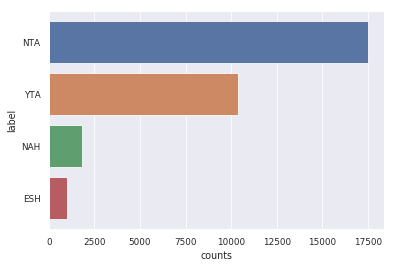

In [33]:
label_counts = good_submissions_df.label.value_counts().to_frame()
label_counts.columns = ['counts']
label_counts['label'] = label_counts.index
sns.barplot(y='label', x='counts', data=label_counts)
plt.plot()

## Train Test Split

Eliminates the posts that have an unknown label, and splits our huge dataset into a train/val/test split.

In [55]:
dataset_df = good_submissions_df[good_submissions_df.label != 'UNK']

In [56]:
test_dataset_df = dataset_df.sample(frac=0.1)

In [57]:
traindev_dataset_df = dataset_df.drop(test_dataset_df.index)

In [58]:
train_dataset_df = traindev_dataset_df.sample(frac=0.8)
dev_dataset_df = traindev_dataset_df.drop(train_dataset_df.index)

In [59]:
dev_dataset_df.to_pickle('../aita/aita-dev.pkl')
train_dataset_df.to_pickle('../aita/aita-train.pkl')
test_dataset_df.to_pickle('../aita/aita-test.pkl')

In [60]:
test_dataset_df.label.value_counts() / test_dataset_df.label.value_counts().sum()

NTA    0.576547
YTA    0.331922
NAH    0.057003
ESH    0.034528
Name: label, dtype: float64

In [61]:
dev_dataset_df.label.value_counts() / dev_dataset_df.label.value_counts().sum()

NTA    0.560724
YTA    0.343529
NAH    0.063348
ESH    0.032398
Name: label, dtype: float64

Linear regression

In [80]:
test_dataset_df['selftext']

23748    Recently, I attended a funeral. One mourner wa...
23601    Everyone involved is 22-25. \n\nFor my birthda...
20210                                            [deleted]
19092    My family have a tradition where we go on a fa...
20375    This happened a few years ago, but I have alwa...
14750    It's his bday and it was brought up last night...
19111    So some short backstory, I go to music school ...
27135    Cast;\n\nme - me\n\nOF - Organizer Friend\n\nA...
7593     So I am an 18 year old male who is attending a...
10582                                            [deleted]
7806     My mother is notoriously tight with her money....
21253    A family member told me a few times over the l...
23196    So I have this friend (let's call him MK). Abo...
19528                                            [deleted]
1504     I attended a music festival/concert with my gi...
15094                                            [removed]
9503     Hey, so for context I have been dating my boyf.

limit_output extension: Maximum message size of 10000 exceeded with 181161 characters

In [76]:
import re


def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text


from sklearn.feature_extraction.text import CountVectorizer


training_texts = [
    "This is a good cat",
    "This is a bad day"
]

test_texts = [
    "This day is a good day"
]

# this vectorizer will skip stop words
vectorizer = CountVectorizer(
    stop_words="english",
    preprocessor=clean_text
)

# fit the vectorizer on the training text
vectorizer.fit(training_texts)

# get the vectorizer's vocabulary
inv_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
vocabulary = [inv_vocab[i] for i in range(len(inv_vocab))]

# vectorization example
pd.DataFrame(
    data=vectorizer.transform(test_texts).toarray(),
    index=["test sentence"],
    columns=vocabulary
)

,bad,cat,day,good
test sentence,0,0,2,1
